In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import scipy.stats as stats
import sqlite3
import pylab as pl
import plotly
import pyspark.pandas as ps
import plotly.graph_objs as go
import seaborn as sns
import sys
import os
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
from plotly.offline import init_notebook_mode, iplot
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.functions import isnan, when, count, col
spark = SparkSession.builder.master('local[*]').getOrCreate()
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from pyspark.ml.feature import SQLTransformer
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.tree import RandomForest
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor

In [12]:
# Read in S&P 500 data set using pandas
financials = pd.read_csv("financials.csv") 
financials.head()


,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,1.387210e+11,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,1.813860e+11,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...


In [13]:
df=financials[["Sector","Name"]]
df.head()

,Sector,Name
0,Industrials,3M Company
1,Industrials,A.O. Smith Corp
2,Health Care,Abbott Laboratories
3,Health Care,AbbVie Inc.
4,Information Technology,Accenture plc


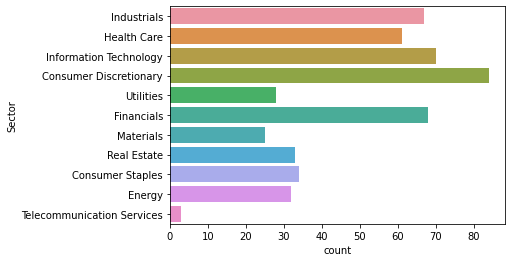

In [15]:
# to know more about dataset and check whether has any error or misspelling( to replace the new name or not)
# how many companies in each categories
sns.countplot(y='Sector',data =df)
plt.show()

In [16]:
financials.Sector.unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real Estate', 'Consumer Staples', 'Energy',
       'Telecommunication Services'], dtype=object)

In [17]:
# replace the name 
financials.replace('Telecommunication Services','Tele Service',inplace=True)

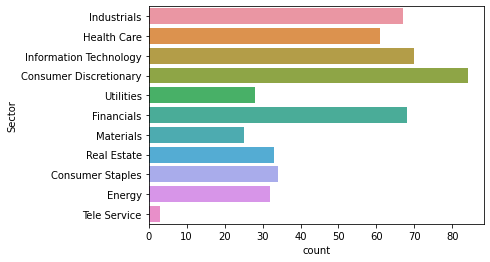

In [19]:
sns.countplot(y='Sector',data =financials)
plt.show()

In [20]:
#learn the pattern of data
financials.replace('Materials','Industrials',inplace=True)
financials.replace(['Tele Service','Utilities','Real Estate'],'other',inplace=True)

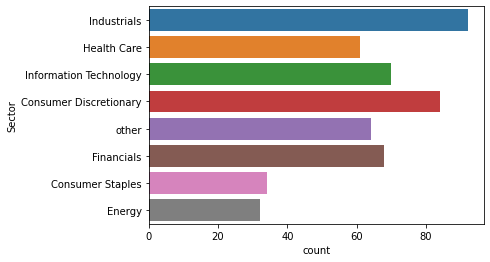

In [21]:
sns.countplot(y='Sector',data =financials)
plt.show()

In [30]:
financials.shape
#505 observations and 14 features

(505, 14)

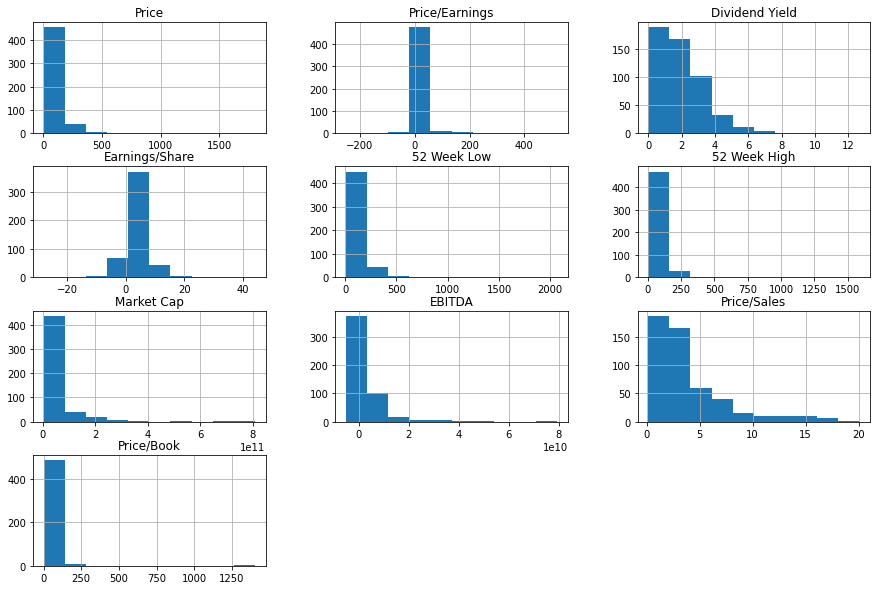

In [33]:
#spotting outliers with histfunction
#determine what include or exclude the data set
# numerica variable-continous features
financials.hist(figsize=(15,10))
plt.show()
# market cap may have one big outlier

In [41]:
financials[financials['Market Cap']>6e+11]

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
27,GOOGL,Alphabet Inc Class A,Information Technology,1007.71,31.48,0.000000,22.27,1198.00,824.3000,7.338240e+11,3.421700e+10,6.801692,4.70,http://www.sec.gov/cgi-bin/browse-edgar?action...
28,GOOG,Alphabet Inc Class C,Information Technology,1001.52,40.29,0.000000,22.27,1186.89,803.1903,7.285360e+11,3.271400e+10,6.772653,4.67,http://www.sec.gov/cgi-bin/browse-edgar?action...
30,AMZN,Amazon.com Inc,Consumer Discretionary,1350.50,296.16,0.000000,6.16,1498.00,812.5000,6.858730e+11,1.613200e+10,3.927053,24.28,http://www.sec.gov/cgi-bin/browse-edgar?action...
51,AAPL,Apple Inc.,Information Technology,155.15,16.86,1.579541,9.20,180.10,131.1200,8.095080e+11,7.938600e+10,3.458609,5.66,http://www.sec.gov/cgi-bin/browse-edgar?action...
311,MSFT,Microsoft Corp.,Information Technology,85.01,25.76,1.874791,2.97,96.07,63.2200,6.899780e+11,4.107900e+10,7.113097,9.49,http://www.sec.gov/cgi-bin/browse-edgar?action...


In [43]:
financials[financials['EBITDA']>6e+10]

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
51,AAPL,Apple Inc.,Information Technology,155.15,16.86,1.579541,9.2,180.1,131.12,8.095080e+11,7.938600e+10,3.458609,5.66,http://www.sec.gov/cgi-bin/browse-edgar?action...
